In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [64]:
class SIR(nn.Module):
    def __init__(self):
        super(SIR, self).__init__()
        self.lambda1 = nn.Linear(1,1, bias = False) 
        self.lambda2 = nn.Linear(1,1, bias = False) 
        self.lambda3 = nn.Linear(1,1) 
        self.lambda4 = nn.Linear(1,1, bias = False)
        
    def forward(self, x, n):
        x = x.reshape(4)
        ns = [torch.zeros(4,dtype=torch.float, requires_grad = False) for i in range(n)]
        ns[0] = x
        for i in range(1,n):
            ns[i][0] = ns[i-1][0] - self.lambda2(self.lambda2(ns[i-1][0].view(1,1)))\
                        -  self.lambda4(self.lambda4(ns[i-1][0].view(1,1))) +\
                        self.lambda3(self.lambda3((ns[i-1][0]/1000*ns[i-1][2]).view(1,1)))
            ns[i][1] = ns[i-1][1] + self.lambda2(self.lambda2(ns[i-1][0].view(1,1)))
            ns[i][2] = ns[i-1][2] - self.lambda3(self.lambda3((ns[i-1][0]/1000*ns[i-1][2]).view(1,1)))
            ns[i][3] = ns[i-1][3] + self.lambda4(self.lambda4(ns[i-1][0].view(1,1)))
        ns[1] = ns[1].reshape(1,4)
        for i in range(2,n):
            ns[i] = ns[i].reshape(1,4)
            ns[1] = torch.cat((ns[1],ns[i]), dim=0)
            ns[1] = ns[1].reshape(-1,4)
        return ns[1]

In [65]:
import pandas as pd
import numpy as np

In [66]:
data_path = 'china_DailyList_2020_02_12.csv'
df = pd.read_csv(data_path, usecols=['confirm','suspect','dead','heal'])

In [67]:
import copy
data = np.array(df)
healed = copy.deepcopy(data[:,2:])
total = 100000 #Assume that total Susceptible is 100000
for i in range(len(data)):
    data[i,0] -= data[i,2] + data[i,3] #calculated the currently comfirmed case
for dat in data:
    dat[2] = (total - dat[1] - dat[0]) #calculate the rest of Susceptible
for dat in data:
    dat[1] = dat[3]
for i,dat in enumerate(data):
    dat[3] = healed[i][0]

In [78]:
y = torch.from_numpy(data.astype(np.float32))/100
#downscaled by 100 to avoid gradient explosion
sir = SIR()
opt = torch.optim.Adam(sir.parameters(), lr=0.05)
loss_func = nn.SmoothL1Loss()
best = 10000
for epoch in range(1000):
    out = sir(y[0], 32)
    out = out.squeeze()
    loss = loss_func(out, y[1:])
    loss.backward()
    opt.step() 
    opt.zero_grad()
    if loss.item() < best:
        best = loss.item()
        torch.save(sir, 'sir.pkl')
    if epoch%100 == 0:        
        print('loss: {}'.format(loss.item()))

loss: 119.88440704345703
loss: 98.45426940917969
loss: 27.573543548583984
loss: 26.62078094482422
loss: 26.575002670288086
loss: 26.5738582611084
loss: 26.574106216430664
loss: 26.574254989624023
loss: 29.03837013244629
loss: 26.759445190429688


In [79]:
import matplotlib.pyplot as plt
%matplotlib inline
model = torch.load('sir.pkl')
window = 10
y = torch.from_numpy(data.astype(np.float32))/100
h = y[0]
res = model(h,85)
res = res.tolist()

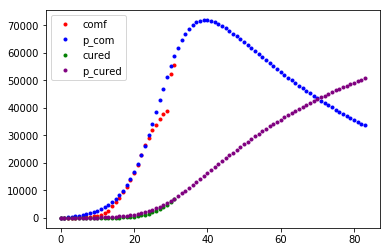

In [80]:
cirm = [0]*len(res)
cirm[0] = y[0][0]*100
rec = [0]*len(res)
rec[0] = y[0][1]*100
real = [0]*32
realc = [0]*32
real[0] = y[0][0]*100
realc[0] = y[0][1]*100
read = [0]*32
di = [0]*len(res)
realt = [0]*32
total = [0]*len(res)
total[0] = (y[0][0] + y[0][1] + y[0][3])*100
realt[0] = (y[0][0] + y[0][1] + y[0][3])*100
ma = 0
ma_i = 0
for i in range(1, len(res)):
    cirm[i] = res[i - 1][0]*100
    rec[i] = res[i-1][1]*100
    di[i] = res[i-1][3]*100
    total[i] = (res[i-1][0] + res[i-1][1] + res[i-1][3])*100
    if cirm[i] > ma:
        ma = cirm[i]
        ma_i = i
    if i < 32:
        real[i] = y[i][0]*100
        realc[i] = y[i][1]*100
        read[i] = y[i][3]*100
        realt[i] = (y[i][0] + y[i][1] + y[i][3])*100
plt.plot(real, color = 'r', linewidth=0, marker='.', label='comf')
plt.plot(cirm, color = 'b', linewidth=0, marker='.', label='p_com')
plt.plot(realc, color = 'g', linewidth=0, marker='.', label='cured')
plt.plot(rec, color = 'purple', linewidth=0, marker='.', label='p_cured')
plt.legend()
plt.savefig('prediction.png', format='png', linewidth = 0.01)